# Coursera Capstone Project: Battle of the Neighborhooods
## Analyzing potential public working spaces in New York

In [3]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

!conda install -c conda-forge wordcloud==1.4.1 --yes
from wordcloud import WordCloud, STOPWORDS

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    certifi-2020.4.5.2         |   py36h9f0ad1d_0         152 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ca-certificates-2020.4.5.2 |       hecda079_0         147 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0           conda-forge
    geopy:          

### Import new york neighborhood data and transform into a pandas dataframe

In [4]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [5]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [6]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

In [7]:
neighborhoods_data = newyork_data['features']

In [8]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [9]:
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
neighborhoods = pd.DataFrame(columns=column_names)

In [10]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [11]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


### Narrow dataset to neighborhoods in Manhattan

In [12]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [13]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


In [14]:
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

### Import Foursquare API and transform into a pandas dataframe

In [15]:
CLIENT_ID = '0YG3QWD01JRK1JNKKMQVAF4S1TLWYT5DP3GQHDXP1MJXHATG'
CLIENT_SECRET = 'EGHHBDZVIQWMGMMWLJOGXUJYUCLGR3PVZEYYGBPHESSZUCNE'
VERSION = '20200605'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 0YG3QWD01JRK1JNKKMQVAF4S1TLWYT5DP3GQHDXP1MJXHATG
CLIENT_SECRET:EGHHBDZVIQWMGMMWLJOGXUJYUCLGR3PVZEYYGBPHESSZUCNE


In [16]:
neighborhood_latitude = manhattan_data.loc[0, 'Latitude']
neighborhood_longitude = manhattan_data.loc[0, 'Longitude']

neighborhood_name = manhattan_data.loc[0, 'Neighborhood']

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Marble Hill are 40.87655077879964, -73.91065965862981.


In [17]:
LIMIT = 500

radius = 500

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=0YG3QWD01JRK1JNKKMQVAF4S1TLWYT5DP3GQHDXP1MJXHATG&client_secret=EGHHBDZVIQWMGMMWLJOGXUJYUCLGR3PVZEYYGBPHESSZUCNE&v=20200605&ll=40.87655077879964,-73.91065965862981&radius=500&limit=500'

In [18]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ee155de8e934821814759f4'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Marble Hill',
  'headerFullLocation': 'Marble Hill, New York',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 25,
  'suggestedBounds': {'ne': {'lat': 40.88105078329964,
    'lng': -73.90471933917806},
   'sw': {'lat': 40.87205077429964, 'lng': -73.91659997808156}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b4429abf964a52037f225e3',
       'name': "Arturo's",
       'location': {'address': '5198 Broadway',
        'crossStreet': 'at 225th St.',
        'lat': 40.87441177110231,
        'lng': -73.91027100981574,
        'labeledLatLngs': [{'label'

In [19]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [20]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues)

filtered_columns = ['venue.name', 'venue.id', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,id,categories,lat,lng
0,Arturo's,4b4429abf964a52037f225e3,Pizza Place,40.874412,-73.910271
1,Bikram Yoga,4baf59e8f964a520a6f93be3,Yoga Studio,40.876844,-73.906204
2,Tibbett Diner,4b79cc46f964a520c5122fe3,Diner,40.880404,-73.908937
3,Starbucks,55f81cd2498ee903149fcc64,Coffee Shop,40.877531,-73.905582
4,Dunkin',4b5357adf964a520319827e3,Donut Shop,40.877136,-73.906666


In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['id'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood_Latitude', 
                  'Neighborhood_Longitude', 
                  'Venue',
                  'Venue_ID',
                  'Venue_Latitude', 
                  'Venue_Longitude', 
                  'Venue_Category']
    
    return(nearby_venues)

In [22]:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


In [23]:
print(manhattan_venues.shape)
manhattan_venues.head()

(3121, 8)


,Neighborhood,Neighborhood_Latitude,Neighborhood_Longitude,Venue,Venue_ID,Venue_Latitude,Venue_Longitude,Venue_Category
0,Marble Hill,40.876551,-73.91066,Arturo's,4b4429abf964a52037f225e3,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,4baf59e8f964a520a6f93be3,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,4b79cc46f964a520c5122fe3,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Starbucks,55f81cd2498ee903149fcc64,40.877531,-73.905582,Coffee Shop
4,Marble Hill,40.876551,-73.91066,Dunkin',4b5357adf964a520319827e3,40.877136,-73.906666,Donut Shop


### Narrow down dataset to only include venues in Manhattan with a venue category of 'Coffee Shop'

In [24]:
venues_coffee = manhattan_venues.loc[(manhattan_venues['Venue_Category'] == 'Coffee Shop') ]

In [25]:
venues_coffee.shape

(143, 8)

In [26]:
venues_coffee.head()

,Neighborhood,Neighborhood_Latitude,Neighborhood_Longitude,Venue,Venue_ID,Venue_Latitude,Venue_Longitude,Venue_Category
3,Marble Hill,40.876551,-73.910660,Starbucks,55f81cd2498ee903149fcc64,40.877531,-73.905582,Coffee Shop
8,Marble Hill,40.876551,-73.910660,Starbucks,57655be738faa66160da7527,40.873755,-73.908613,Coffee Shop
74,Chinatown,40.715618,-73.994279,Little Canal,579f74eb498e9a4d6caabeda,40.714317,-73.990361,Coffee Shop
97,Chinatown,40.715618,-73.994279,Cafe Grumpy,4df7603c7d8b5f396ac5cfd5,40.715069,-73.989952,Coffee Shop
111,Chinatown,40.715618,-73.994279,Oliver Coffee,5878d46d52a05106f220729c,40.712986,-73.998106,Coffee Shop


### Let's visualize the number of coffee shops per neighborhood

In [27]:
venues_count = venues_coffee.groupby(['Neighborhood'])['Neighborhood'].count()
venues_sorted = venues_count.sort_values(ascending=False)
venues_sorted.head(10)

Neighborhood
Carnegie Hill         8
Chelsea               8
Financial District    8
Yorkville             7
Civic Center          6
Sutton Place          6
Lenox Hill            6
Midtown               5
Upper East Side       5
Clinton               5
Name: Neighborhood, dtype: int64

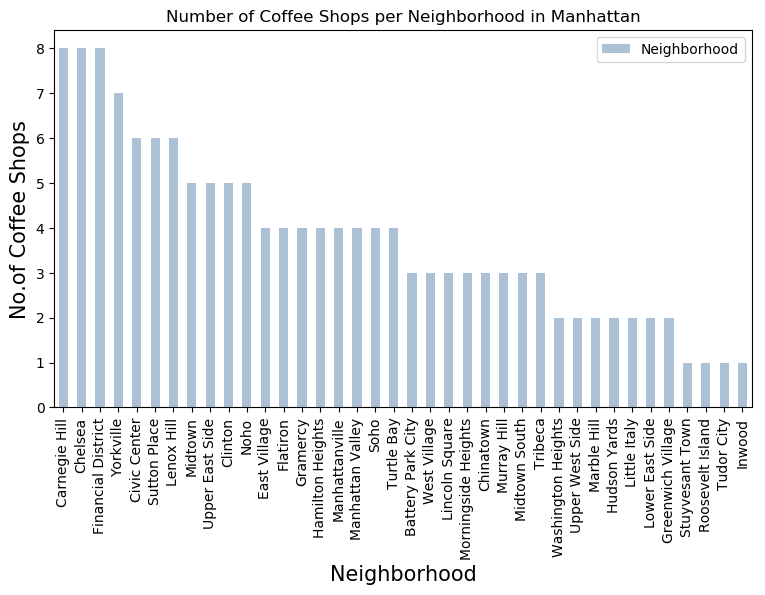

In [28]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of Coffee Shops per Neighborhood in Manhattan')
plt.xlabel('Neighborhoods', fontsize = 15)
plt.ylabel('No.of Coffee Shops', fontsize=15)
venues_sorted.plot(kind='bar', color=(0.2, 0.4, 0.6, 0.4))
plt.legend()
plt.show()

### Let's analyze further the three top neighborhoods: Carnegie Hill, Chelsea, and Financial District. Let's explore the tips from Carnegie Hill first.  
#### (Note: For loops wouldn't work for json so I've retrieved the data individually, this is not the optimal approach)

In [29]:
carnegie_coffee = venues_coffee.loc[(venues_coffee['Neighborhood'] == 'Carnegie Hill')]
carnegie_coffee

,Neighborhood,Neighborhood_Latitude,Neighborhood_Longitude,Venue,Venue_ID,Venue_Latitude,Venue_Longitude,Venue_Category
2292,Carnegie Hill,40.782683,-73.953256,Jack’s Stir Brew Coffee,5b784d8d037be1002c195155,40.781152,-73.954383,Coffee Shop
2307,Carnegie Hill,40.782683,-73.953256,Birch Coffee,599d7c7e61f0700d414c282b,40.780275,-73.953445,Coffee Shop
2318,Carnegie Hill,40.782683,-73.953256,DTUT,51ae935b7dd2de27a217609e,40.780818,-73.949350,Coffee Shop
2346,Carnegie Hill,40.782683,-73.953256,Variety Coffee Roasters,5abb96b31f8ed641d150eafa,40.778899,-73.955900,Coffee Shop
2353,Carnegie Hill,40.782683,-73.953256,Starbucks,57fd457a498e39cd34012586,40.782715,-73.948169,Coffee Shop
2362,Carnegie Hill,40.782683,-73.953256,Starbucks,5330323b498e2836f173cf9e,40.779546,-73.953552,Coffee Shop
2365,Carnegie Hill,40.782683,-73.953256,The Brown Cup,4da39a219935a0933d0bcd6f,40.779486,-73.950606,Coffee Shop
2372,Carnegie Hill,40.782683,-73.953256,Go Cups,552a7fbb498e1e8662ac8146,40.783511,-73.947570,Coffee Shop


### Cannot retrieve tips for first venue in Carnegie Hill

In [30]:
venue_id = '5b784d8d037be1002c195155'
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

result = requests.get(url).json()
print(result['response']['venue'].keys())
result['response']['venue']

limit = 2
url = 'https://api.foursquare.com/v2/venues/{}/tips?client_id={}&client_secret={}&v={}&limit={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION, limit)
results = requests.get(url).json()

tips = results['response']['tips']['items']
tip = results['response']['tips']['items'][0]

pd.set_option('display.max_colwidth', -1)
tips_df = json_normalize(tips)

filtered_columns = ['venue_id','text', 'agreeCount', 'disagreeCount', 'id', 'user.firstName', 'user.lastName', 'user.id']
carnegie_filtered = tips_df.loc[:, filtered_columns]
carnegie_filtered['venue_id'] = carnegie_filtered['venue_id'].fillna(venue_id)
carnegie_filtered

dict_keys(['id', 'name', 'contact', 'location', 'canonicalUrl', 'categories', 'verified', 'stats', 'price', 'likes', 'dislike', 'ok', 'rating', 'ratingColor', 'ratingSignals', 'allowMenuUrlEdit', 'beenHere', 'specials', 'photos', 'reasons', 'hereNow', 'createdAt', 'tips', 'shortUrl', 'timeZone', 'listed', 'seasonalHours', 'pageUpdates', 'inbox', 'attributes', 'bestPhoto', 'colors'])


IndexError: list index out of range

In [33]:
venue_id = '599d7c7e61f0700d414c282b'
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

result = requests.get(url).json()
print(result['response']['venue'].keys())
result['response']['venue']

limit = 2
url = 'https://api.foursquare.com/v2/venues/{}/tips?client_id={}&client_secret={}&v={}&limit={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION, limit)
results = requests.get(url).json()

tips = results['response']['tips']['items']
tip = results['response']['tips']['items'][0]

pd.set_option('display.max_colwidth', -1)
tips_df = json_normalize(tips)

filtered_columns = ['venue_id','text', 'agreeCount', 'disagreeCount', 'id', 'user.firstName', 'user.lastName', 'user.id']
carnegie_filtered2 = tips_df.loc[:, filtered_columns]
carnegie_filtered2['venue_id'] = carnegie_filtered2['venue_id'].fillna(venue_id)
carnegie_filtered2

dict_keys(['id', 'name', 'contact', 'location', 'canonicalUrl', 'categories', 'verified', 'stats', 'url', 'price', 'likes', 'dislike', 'ok', 'rating', 'ratingColor', 'ratingSignals', 'allowMenuUrlEdit', 'beenHere', 'specials', 'photos', 'reasons', 'hereNow', 'createdAt', 'tips', 'shortUrl', 'timeZone', 'listed', 'hours', 'popular', 'seasonalHours', 'defaultHours', 'pageUpdates', 'inbox', 'attributes', 'bestPhoto'])


,venue_id,text,agreeCount,disagreeCount,id,user.firstName,user.lastName,user.id
0,599d7c7e61f0700d414c282b,Easily the best drip coffee on the UES. Shop is very small with minimal seating. Good source for reasonably priced coffee beans.,7,0,5ad2f97a2b274a567b19718e,Eddie,E,8757931
1,599d7c7e61f0700d414c282b,"Nice coffee spot, great coffee and friendly barista! Try their raw bars Lenka - so yummie!",4,0,5a93f1320ff4f9481ff5dcba,Adley,NaN,6085279


In [34]:
venue_id = '51ae935b7dd2de27a217609e'
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

result = requests.get(url).json()
print(result['response']['venue'].keys())
result['response']['venue']

limit = 2
url = 'https://api.foursquare.com/v2/venues/{}/tips?client_id={}&client_secret={}&v={}&limit={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION, limit)
results = requests.get(url).json()

tips = results['response']['tips']['items']
tip = results['response']['tips']['items'][0]

pd.set_option('display.max_colwidth', -1)
tips_df = json_normalize(tips)

filtered_columns = ['venue_id','text', 'agreeCount', 'disagreeCount', 'id', 'user.firstName', 'user.lastName', 'user.id']
carnegie_filtered3 = tips_df.loc[:, filtered_columns]
carnegie_filtered3['venue_id'] = carnegie_filtered3['venue_id'].fillna(venue_id)
carnegie_filtered3

dict_keys(['id', 'name', 'contact', 'location', 'canonicalUrl', 'categories', 'verified', 'stats', 'url', 'price', 'likes', 'dislike', 'ok', 'rating', 'ratingColor', 'ratingSignals', 'menu', 'allowMenuUrlEdit', 'beenHere', 'specials', 'photos', 'venuePage', 'reasons', 'page', 'hereNow', 'createdAt', 'tips', 'shortUrl', 'timeZone', 'listed', 'hours', 'popular', 'seasonalHours', 'defaultHours', 'pageUpdates', 'inbox', 'attributes', 'bestPhoto', 'colors'])


,venue_id,text,agreeCount,disagreeCount,id,user.firstName,user.lastName,user.id
0,51ae935b7dd2de27a217609e,"The Irving Farm coffee is excellent, and the rustic aesthetic is a perfect compliment to a robust brew. The service staff is personable and chill, and the cozy environment is the perfect city escape.",7,0,557f1612498ee555b942e09f,Josiah David,C,62505272
1,51ae935b7dd2de27a217609e,"Just an all around great neighborhood spot for yummy pastries, good fresh roast coffee, good atmosphere/customer service, coziness, and wifi...within 60 sec walk from home! score.",7,0,54e374c7498edb2a1d4d5d33,Lanre,A,52161641


In [35]:
venue_id = '5abb96b31f8ed641d150eafa'
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

result = requests.get(url).json()
print(result['response']['venue'].keys())
result['response']['venue']

limit = 2
url = 'https://api.foursquare.com/v2/venues/{}/tips?client_id={}&client_secret={}&v={}&limit={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION, limit)
results = requests.get(url).json()

tips = results['response']['tips']['items']
tip = results['response']['tips']['items'][0]

pd.set_option('display.max_colwidth', -1)
tips_df = json_normalize(tips)

filtered_columns = ['venue_id','text', 'agreeCount', 'disagreeCount', 'id', 'user.firstName', 'user.lastName', 'user.id']
carnegie_filtered4 = tips_df.loc[:, filtered_columns]
carnegie_filtered4['venue_id'] = carnegie_filtered4['venue_id'].fillna(venue_id)
carnegie_filtered4

dict_keys(['id', 'name', 'contact', 'location', 'canonicalUrl', 'categories', 'verified', 'stats', 'url', 'price', 'likes', 'dislike', 'ok', 'rating', 'ratingColor', 'ratingSignals', 'allowMenuUrlEdit', 'beenHere', 'specials', 'photos', 'reasons', 'hereNow', 'createdAt', 'tips', 'shortUrl', 'timeZone', 'listed', 'hours', 'popular', 'seasonalHours', 'defaultHours', 'pageUpdates', 'inbox', 'attributes', 'bestPhoto', 'colors'])


,venue_id,text,agreeCount,disagreeCount,id,user.firstName,user.lastName,user.id
0,5abb96b31f8ed641d150eafa,"Finally! A new specialty coffee shop close to the UES 86th subway (on the same location as the recently closed Petite Shell). Everything tasted terrific so far, from espresso, cortado to batch brew.",12,0,5abbb47667f62b57ee93743d,Jiri,D,88151980
1,5abb96b31f8ed641d150eafa,Very classy but welcoming interior. It was surprisingly empty and would be an excellent alternative to Cafe Jax if you like working at coffee shops.,5,0,5ac984f4e65d0c69c40152da,Mika,S,136200186


In [36]:
venue_id = '57fd457a498e39cd34012586'
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

result = requests.get(url).json()
print(result['response']['venue'].keys())
result['response']['venue']

limit = 2
url = 'https://api.foursquare.com/v2/venues/{}/tips?client_id={}&client_secret={}&v={}&limit={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION, limit)
results = requests.get(url).json()

tips = results['response']['tips']['items']
tip = results['response']['tips']['items'][0]

pd.set_option('display.max_colwidth', -1)
tips_df = json_normalize(tips)

filtered_columns = ['venue_id','text', 'agreeCount', 'disagreeCount', 'id', 'user.firstName', 'user.lastName', 'user.id']
carnegie_filtered5 = tips_df.loc[:, filtered_columns]
carnegie_filtered5['venue_id'] = carnegie_filtered5['venue_id'].fillna(venue_id)
carnegie_filtered5

dict_keys(['id', 'name', 'contact', 'location', 'canonicalUrl', 'categories', 'verified', 'stats', 'url', 'price', 'likes', 'dislike', 'ok', 'rating', 'ratingColor', 'ratingSignals', 'menu', 'allowMenuUrlEdit', 'beenHere', 'specials', 'photos', 'reasons', 'description', 'storeId', 'page', 'hereNow', 'createdAt', 'tips', 'shortUrl', 'timeZone', 'listed', 'hours', 'popular', 'seasonalHours', 'defaultHours', 'pageUpdates', 'inbox', 'attributes', 'bestPhoto', 'colors'])


,venue_id,text,agreeCount,disagreeCount,id,user.firstName,user.lastName,user.id
0,57fd457a498e39cd34012586,"Decent sized, friendly staff. Perfect stop for the morning commute.",4,0,5809edb438fa13326b3faab1,Molly,S,14099684
1,57fd457a498e39cd34012586,"Even though the official address is listed as 245 E. 93rd St., it's actually on second Avenue between 93rd and 94th Streets.",3,0,587015a3f84085303f50f35e,Alvin,S,87761942


In [37]:
venue_id = '5330323b498e2836f173cf9e'
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

result = requests.get(url).json()
print(result['response']['venue'].keys())
result['response']['venue']

limit = 2
url = 'https://api.foursquare.com/v2/venues/{}/tips?client_id={}&client_secret={}&v={}&limit={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION, limit)
results = requests.get(url).json()

tips = results['response']['tips']['items']
tip = results['response']['tips']['items'][0]

pd.set_option('display.max_colwidth', -1)
tips_df = json_normalize(tips)

filtered_columns = ['venue_id','text', 'agreeCount', 'disagreeCount', 'id', 'user.firstName', 'user.lastName', 'user.id']
carnegie_filtered6 = tips_df.loc[:, filtered_columns]
carnegie_filtered6['venue_id'] = carnegie_filtered6['venue_id'].fillna(venue_id)
carnegie_filtered6

dict_keys(['id', 'name', 'contact', 'location', 'canonicalUrl', 'categories', 'verified', 'stats', 'url', 'price', 'likes', 'dislike', 'ok', 'rating', 'ratingColor', 'ratingSignals', 'menu', 'allowMenuUrlEdit', 'beenHere', 'specials', 'photos', 'reasons', 'description', 'storeId', 'page', 'hereNow', 'createdAt', 'tips', 'shortUrl', 'timeZone', 'listed', 'hours', 'popular', 'seasonalHours', 'defaultHours', 'pageUpdates', 'inbox', 'attributes', 'bestPhoto', 'colors'])


,venue_id,text,agreeCount,disagreeCount,id,user.firstName,user.lastName,user.id
0,5330323b498e2836f173cf9e,"The space is nice, and I easily found and used outlets for my devices. Enjoy a cold brew with a Magpies tart! Delicious.",3,0,55cb5b62498e9ccd7c0babbe,Nia,S,32910677
1,5330323b498e2836f173cf9e,"New to the locality - it's spacious, and has plenty of seating by the glass windows - for those who love their coffee with a view!",3,0,5342eca411d2cfa327da7af6,Nirav,S,54562222


In [38]:
venue_id = '4da39a219935a0933d0bcd6f'
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

result = requests.get(url).json()
print(result['response']['venue'].keys())
result['response']['venue']

limit = 2
url = 'https://api.foursquare.com/v2/venues/{}/tips?client_id={}&client_secret={}&v={}&limit={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION, limit)
results = requests.get(url).json()

tips = results['response']['tips']['items']
tip = results['response']['tips']['items'][0]

pd.set_option('display.max_colwidth', -1)
tips_df = json_normalize(tips)

filtered_columns = ['venue_id','text', 'agreeCount', 'disagreeCount', 'id', 'user.firstName', 'user.lastName', 'user.id']
carnegie_filtered7 = tips_df.loc[:, filtered_columns]
carnegie_filtered7['venue_id'] = carnegie_filtered7['venue_id'].fillna(venue_id)
carnegie_filtered7

dict_keys(['id', 'name', 'contact', 'location', 'canonicalUrl', 'categories', 'verified', 'stats', 'price', 'likes', 'dislike', 'ok', 'rating', 'ratingColor', 'ratingSignals', 'allowMenuUrlEdit', 'beenHere', 'specials', 'photos', 'reasons', 'hereNow', 'createdAt', 'tips', 'shortUrl', 'timeZone', 'listed', 'hours', 'popular', 'seasonalHours', 'defaultHours', 'pageUpdates', 'inbox', 'attributes', 'bestPhoto', 'colors'])


,venue_id,text,agreeCount,disagreeCount,id,user.firstName,user.lastName,user.id
0,4da39a219935a0933d0bcd6f,The girls who work here are extremely friendly and are so pleasant when I stop in at 7:15 on my way to work. The best(less than $5) bacon egg&cheese in the neighborhood! Great coffee and smoothies,6,0,51c755ca498e5b52235d8cc9,Spencer,V,59170133
1,4da39a219935a0933d0bcd6f,"Fast service from very friendly staff. When I struggle to get going on a weekend morning, they save me. Prices are a little high, but also larger size cups than most nearby places.",0,0,55293a6f498e007382819ab7,Drew,S,38498334


In [39]:
venue_id = '552a7fbb498e1e8662ac8146'
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

result = requests.get(url).json()
print(result['response']['venue'].keys())
result['response']['venue']

limit = 2
url = 'https://api.foursquare.com/v2/venues/{}/tips?client_id={}&client_secret={}&v={}&limit={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION, limit)
results = requests.get(url).json()

tips = results['response']['tips']['items']
tip = results['response']['tips']['items'][0]

pd.set_option('display.max_colwidth', -1)
tips_df = json_normalize(tips)

filtered_columns = ['venue_id','text', 'agreeCount', 'disagreeCount', 'id', 'user.firstName', 'user.lastName', 'user.id']
carnegie_filtered8 = tips_df.loc[:, filtered_columns]
carnegie_filtered8['venue_id'] = carnegie_filtered8['venue_id'].fillna(venue_id)
carnegie_filtered8

dict_keys(['id', 'name', 'contact', 'location', 'canonicalUrl', 'categories', 'verified', 'stats', 'price', 'likes', 'dislike', 'ok', 'rating', 'ratingColor', 'ratingSignals', 'delivery', 'allowMenuUrlEdit', 'beenHere', 'specials', 'photos', 'reasons', 'hereNow', 'createdAt', 'tips', 'shortUrl', 'timeZone', 'listed', 'hours', 'popular', 'seasonalHours', 'defaultHours', 'pageUpdates', 'inbox', 'attributes', 'bestPhoto', 'colors'])


,venue_id,text,agreeCount,disagreeCount,id,user.firstName,user.lastName,user.id
0,552a7fbb498e1e8662ac8146,Good local spot to pick up a quick breakfast scone and coffee or a smoothie for lunch. Very clean place with friendly help behind the counters.,0,0,57e528a4498e4be3d0487140,Cindy,O,1389507
1,552a7fbb498e1e8662ac8146,"Great variety of juices, smoothies and açai bowls after my workouts at Synergy. They also have frozen yogurt for the kids younger and older. ;)",0,0,5d8668a2f96bc00007b08776,Alvin,S,87761942


In [191]:
carnegie_tips = pd.concat([carnegie_filtered2, carnegie_filtered3, carnegie_filtered4, carnegie_filtered5, carnegie_filtered6, carnegie_filtered7, carnegie_filtered8])
carnegie_tips

,venue_id,text,agreeCount,disagreeCount,id,user.firstName,user.lastName,user.id
0,599d7c7e61f0700d414c282b,Easily the best drip coffee on the UES. Shop is very small with minimal seating. Good source for reasonably priced coffee beans.,7,0,5ad2f97a2b274a567b19718e,Eddie,E,8757931
1,599d7c7e61f0700d414c282b,"Nice coffee spot, great coffee and friendly barista! Try their raw bars Lenka - so yummie!",4,0,5a93f1320ff4f9481ff5dcba,Adley,NaN,6085279
0,51ae935b7dd2de27a217609e,"The Irving Farm coffee is excellent, and the rustic aesthetic is a perfect compliment to a robust brew. The service staff is personable and chill, and the cozy environment is the perfect city escape.",7,0,557f1612498ee555b942e09f,Josiah David,C,62505272
1,51ae935b7dd2de27a217609e,"Just an all around great neighborhood spot for yummy pastries, good fresh roast coffee, good atmosphere/customer service, coziness, and wifi...within 60 sec walk from home! score.",7,0,54e374c7498edb2a1d4d5d33,Lanre,A,52161641
0,5abb96b31f8ed641d150eafa,"Finally! A new specialty coffee shop close to the UES 86th subway (on the same location as the recently closed Petite Shell). Everything tasted terrific so far, from espresso, cortado to batch brew.",12,0,5abbb47667f62b57ee93743d,Jiri,D,88151980
1,5abb96b31f8ed641d150eafa,Very classy but welcoming interior. It was surprisingly empty and would be an excellent alternative to Cafe Jax if you like working at coffee shops.,5,0,5ac984f4e65d0c69c40152da,Mika,S,136200186
0,57fd457a498e39cd34012586,"Decent sized, friendly staff. Perfect stop for the morning commute.",4,0,5809edb438fa13326b3faab1,Molly,S,14099684
1,57fd457a498e39cd34012586,"Even though the official address is listed as 245 E. 93rd St., it's actually on second Avenue between 93rd and 94th Streets.",3,0,587015a3f84085303f50f35e,Alvin,S,87761942
0,5330323b498e2836f173cf9e,"The space is nice, and I easily found and used outlets for my devices. Enjoy a cold brew with a Magpies tart! Delicious.",3,0,55cb5b62498e9ccd7c0babbe,Nia,S,32910677
1,5330323b498e2836f173cf9e,"New to the locality - it's spacious, and has plenty of seating by the glass windows - for those who love their coffee with a view!",3,0,5342eca411d2cfa327da7af6,Nirav,S,54562222


### Now let's retrieve the tips for coffee shops in Chelsea

In [41]:
chelsea_coffee = venues_coffee.loc[(venues_coffee['Neighborhood'] == 'Chelsea')]
chelsea_coffee

,Neighborhood,Neighborhood_Latitude,Neighborhood_Longitude,Venue,Venue_ID,Venue_Latitude,Venue_Longitude,Venue_Category
1246,Chelsea,40.744035,-74.003116,Intelligentsia Coffee,519a94e3498e722d3d9ae1bf,40.745926,-74.005376,Coffee Shop
1259,Chelsea,40.744035,-74.003116,St Kilda Coffee,5cc82d711acf11002c0998f5,40.743854,-73.999770,Coffee Shop
1269,Chelsea,40.744035,-74.003116,Starbucks Reserve Roastery,5c13bf838afbe0002de55061,40.741662,-74.005080,Coffee Shop
1282,Chelsea,40.744035,-74.003116,Terremoto,569aa89d498e5a25c05fdfec,40.740999,-74.003205,Coffee Shop
1284,Chelsea,40.744035,-74.003116,Blue Bottle Coffee,4f3a9e05bb3d2fbe725ca57a,40.742473,-74.006982,Coffee Shop
1309,Chelsea,40.744035,-74.003116,Café Grumpy,45d1a484f964a520af421fe3,40.742573,-73.998390,Coffee Shop
1310,Chelsea,40.744035,-74.003116,Kobrick Coffee Co.,55e9f118498eda28f897f9e3,40.740337,-74.005693,Coffee Shop
1318,Chelsea,40.744035,-74.003116,Blue Bottle Cart,4e14b8abd16447c40d1ae25c,40.742793,-74.007683,Coffee Shop


In [42]:
venue_id = '519a94e3498e722d3d9ae1bf'
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

result = requests.get(url).json()
print(result['response']['venue'].keys())
result['response']['venue']

limit = 2
url = 'https://api.foursquare.com/v2/venues/{}/tips?client_id={}&client_secret={}&v={}&limit={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION, limit)
results = requests.get(url).json()

tips = results['response']['tips']['items']
tip = results['response']['tips']['items'][0]

pd.set_option('display.max_colwidth', -1)
tips_df = json_normalize(tips)

filtered_columns = ['venue_id','text', 'agreeCount', 'disagreeCount', 'id', 'user.firstName', 'user.lastName', 'user.id']
chelsea_filtered = tips_df.loc[:, filtered_columns]
chelsea_filtered['venue_id'] = chelsea_filtered['venue_id'].fillna(venue_id)
chelsea_filtered

dict_keys(['id', 'name', 'contact', 'location', 'canonicalUrl', 'categories', 'verified', 'stats', 'url', 'price', 'likes', 'dislike', 'ok', 'rating', 'ratingColor', 'ratingSignals', 'allowMenuUrlEdit', 'beenHere', 'specials', 'photos', 'venuePage', 'reasons', 'page', 'hereNow', 'createdAt', 'tips', 'shortUrl', 'timeZone', 'listed', 'hours', 'popular', 'seasonalHours', 'defaultHours', 'pageUpdates', 'inbox', 'parent', 'hierarchy', 'attributes', 'bestPhoto', 'colors'])


,venue_id,text,agreeCount,disagreeCount,id,user.firstName,user.lastName,user.id
0,519a94e3498e722d3d9ae1bf,Excellent coffee. Ask for their feature espresso. The truck in the courtyard is fun if the weather is nice. The bar inside the lobby is full of charm. They do have typewriters if you feel like writing,8,0,5778a569498e0548e1c0c77a,Faris,I,83402739
1,519a94e3498e722d3d9ae1bf,Excellent coffee. The flat white is a strong challenger for best in Manhattan. Head into the hotel rather than relying just on the truck in the front. Enjoy the quieter atmosphere in the back garden.,7,0,55e4a50a498e8a3522e0145e,M,W,16725530


In [43]:
venue_id = '5cc82d711acf11002c0998f5'
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

result = requests.get(url).json()
print(result['response']['venue'].keys())
result['response']['venue']

limit = 2
url = 'https://api.foursquare.com/v2/venues/{}/tips?client_id={}&client_secret={}&v={}&limit={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION, limit)
results = requests.get(url).json()

tips = results['response']['tips']['items']
tip = results['response']['tips']['items'][0]

pd.set_option('display.max_colwidth', -1)
tips_df = json_normalize(tips)

filtered_columns = ['venue_id','text', 'agreeCount', 'disagreeCount', 'id', 'user.firstName', 'user.lastName', 'user.id']
chelsea_filtered2 = tips_df.loc[:, filtered_columns]
chelsea_filtered2['venue_id'] = chelsea_filtered2['venue_id'].fillna(venue_id)
chelsea_filtered2

dict_keys(['id', 'name', 'contact', 'location', 'canonicalUrl', 'categories', 'verified', 'stats', 'url', 'price', 'likes', 'dislike', 'ok', 'rating', 'ratingColor', 'ratingSignals', 'allowMenuUrlEdit', 'beenHere', 'specials', 'photos', 'reasons', 'hereNow', 'createdAt', 'tips', 'shortUrl', 'timeZone', 'listed', 'hours', 'popular', 'seasonalHours', 'defaultHours', 'pageUpdates', 'inbox', 'attributes', 'bestPhoto'])


,venue_id,text,agreeCount,disagreeCount,id,user.firstName,user.lastName,user.id
0,5cc82d711acf11002c0998f5,Owner is from Melbourne. Try out the new guys. Give small business our support,3,0,5ccaf8a2a92d98002c18cd99,Howard,NaN,24492479
1,5cc82d711acf11002c0998f5,Cute and much needed coffee shop along 8th Ave in Chelsea. Bright and welcoming - crossing my fingers this stays in business!,0,0,5cdd437212f0a9002c6e9dbb,Mike,N,11111871


In [44]:
venue_id = '5c13bf838afbe0002de55061'
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

result = requests.get(url).json()
print(result['response']['venue'].keys())
result['response']['venue']

limit = 2
url = 'https://api.foursquare.com/v2/venues/{}/tips?client_id={}&client_secret={}&v={}&limit={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION, limit)
results = requests.get(url).json()

tips = results['response']['tips']['items']
tip = results['response']['tips']['items'][0]

pd.set_option('display.max_colwidth', -1)
tips_df = json_normalize(tips)

filtered_columns = ['venue_id','text', 'agreeCount', 'disagreeCount', 'id', 'user.firstName', 'user.lastName', 'user.id']
chelsea_filtered3 = tips_df.loc[:, filtered_columns]
chelsea_filtered3['venue_id'] = chelsea_filtered3['venue_id'].fillna(venue_id)
chelsea_filtered3

dict_keys(['id', 'name', 'contact', 'location', 'canonicalUrl', 'categories', 'verified', 'stats', 'url', 'price', 'likes', 'dislike', 'ok', 'rating', 'ratingColor', 'ratingSignals', 'allowMenuUrlEdit', 'beenHere', 'specials', 'photos', 'reasons', 'hereNow', 'createdAt', 'tips', 'shortUrl', 'timeZone', 'listed', 'hours', 'popular', 'seasonalHours', 'defaultHours', 'pageUpdates', 'inbox', 'attributes', 'bestPhoto', 'colors'])


,venue_id,text,agreeCount,disagreeCount,id,user.firstName,user.lastName,user.id
0,5c13bf838afbe0002de55061,The siphon coffee is smoother than pour over. Try the Jamaican blue mountain. It’s a bit pricey but worth the experience. Baristas are very friendly knowledgeable.,33,0,5c1e8633db2aeb002c1a7f90,Kirk,W,240192
1,5c13bf838afbe0002de55061,"Beautiful coffees, but they are VERY expensive. A lovely adventure, but probably not a fun daily stop. Music is bizarrely loud and inhibits conversation.",29,0,5c168ac4c0c0840025dc8434,Jake,S,417213349


In [45]:
venue_id = '569aa89d498e5a25c05fdfec'
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

result = requests.get(url).json()
print(result['response']['venue'].keys())
result['response']['venue']

limit = 2
url = 'https://api.foursquare.com/v2/venues/{}/tips?client_id={}&client_secret={}&v={}&limit={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION, limit)
results = requests.get(url).json()

tips = results['response']['tips']['items']
tip = results['response']['tips']['items'][0]

pd.set_option('display.max_colwidth', -1)
tips_df = json_normalize(tips)

filtered_columns = ['venue_id','text', 'agreeCount', 'disagreeCount', 'id', 'user.firstName', 'user.lastName', 'user.id']
chelsea_filtered4 = tips_df.loc[:, filtered_columns]
chelsea_filtered4['venue_id'] = chelsea_filtered4['venue_id'].fillna(venue_id)
chelsea_filtered4

dict_keys(['id', 'name', 'contact', 'location', 'canonicalUrl', 'categories', 'verified', 'stats', 'url', 'price', 'likes', 'dislike', 'ok', 'rating', 'ratingColor', 'ratingSignals', 'allowMenuUrlEdit', 'beenHere', 'specials', 'photos', 'reasons', 'hereNow', 'createdAt', 'tips', 'shortUrl', 'timeZone', 'listed', 'hours', 'popular', 'seasonalHours', 'defaultHours', 'pageUpdates', 'inbox', 'attributes', 'bestPhoto', 'colors'])


,venue_id,text,agreeCount,disagreeCount,id,user.firstName,user.lastName,user.id
0,569aa89d498e5a25c05fdfec,"Killer espresso machine. Best lattes around, beating 9th St and Blue bottle. Little gem! Generally no line and nice place to hang for a bit.",4,0,5863c713983631340615da6a,brenda,l,399587
1,569aa89d498e5a25c05fdfec,Adorable coffee shop in my neighborhood. Great coffee. The barista doesn’t like small talk but he will warm up to you eventually.,2,0,5a2c13d667af3a28fe772a5f,Jana,NaN,383781


In [46]:
venue_id = '4f3a9e05bb3d2fbe725ca57a'
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

result = requests.get(url).json()
print(result['response']['venue'].keys())
result['response']['venue']

limit = 2
url = 'https://api.foursquare.com/v2/venues/{}/tips?client_id={}&client_secret={}&v={}&limit={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION, limit)
results = requests.get(url).json()

tips = results['response']['tips']['items']
tip = results['response']['tips']['items'][0]

pd.set_option('display.max_colwidth', -1)
tips_df = json_normalize(tips)

filtered_columns = ['venue_id','text', 'agreeCount', 'disagreeCount', 'id', 'user.firstName', 'user.lastName', 'user.id']
chelsea_filtered5 = tips_df.loc[:, filtered_columns]
chelsea_filtered5['venue_id'] = chelsea_filtered5['venue_id'].fillna(venue_id)
chelsea_filtered5

dict_keys(['id', 'name', 'contact', 'location', 'canonicalUrl', 'categories', 'verified', 'stats', 'url', 'price', 'hasMenu', 'likes', 'dislike', 'ok', 'rating', 'ratingColor', 'ratingSignals', 'menu', 'allowMenuUrlEdit', 'beenHere', 'specials', 'photos', 'reasons', 'hereNow', 'createdAt', 'tips', 'shortUrl', 'timeZone', 'listed', 'hours', 'popular', 'seasonalHours', 'defaultHours', 'pageUpdates', 'inbox', 'attributes', 'bestPhoto', 'colors'])


,venue_id,text,agreeCount,disagreeCount,id,user.firstName,user.lastName,user.id
0,4f3a9e05bb3d2fbe725ca57a,"Incredible coffee from San Francisco. Be sure to check out the Siphon bar upstairs, it's what separates it from other indie shops in the city. It's not a mobile office, so don't bring the laptop.",11,0,514e1dd5e4b040402bfa520d,Kevin,M,5500677
1,4f3a9e05bb3d2fbe725ca57a,"Make damn sure to experience the siphon and Chemex coffee at the siphon bar up the stairs in the back. Near Chelsea market, and has a very open feel to the cafe. Good for 1 on 1 talk.",8,0,52e9f0bc498eb663411e631f,Gloria,NaN,1294016


In [47]:
venue_id = '45d1a484f964a520af421fe3'
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

result = requests.get(url).json()
print(result['response']['venue'].keys())
result['response']['venue']

limit = 2
url = 'https://api.foursquare.com/v2/venues/{}/tips?client_id={}&client_secret={}&v={}&limit={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION, limit)
results = requests.get(url).json()

tips = results['response']['tips']['items']
tip = results['response']['tips']['items'][0]

pd.set_option('display.max_colwidth', -1)
tips_df = json_normalize(tips)

filtered_columns = ['venue_id','text', 'agreeCount', 'disagreeCount', 'id', 'user.firstName', 'user.lastName', 'user.id']
chelsea_filtered6 = tips_df.loc[:, filtered_columns]
chelsea_filtered6['venue_id'] = chelsea_filtered6['venue_id'].fillna(venue_id)
chelsea_filtered6

dict_keys(['id', 'name', 'contact', 'location', 'canonicalUrl', 'categories', 'verified', 'stats', 'url', 'price', 'hasMenu', 'likes', 'dislike', 'ok', 'rating', 'ratingColor', 'ratingSignals', 'menu', 'allowMenuUrlEdit', 'beenHere', 'specials', 'photos', 'reasons', 'description', 'hereNow', 'createdAt', 'tips', 'shortUrl', 'timeZone', 'listed', 'hours', 'popular', 'seasonalHours', 'defaultHours', 'pageUpdates', 'inbox', 'attributes', 'bestPhoto', 'colors'])


,venue_id,text,agreeCount,disagreeCount,id,user.firstName,user.lastName,user.id
0,45d1a484f964a520af421fe3,"The garden at Cafe Grumpy is one of my favorite places to read. It's small, cute, and very quiet, especially in the morning. However, it's currently 7:17am so I guess most of Manhattan is still quiet.",14,0,51a7399d498e044456aabb9d,EsuNYC,.,5081153
1,45d1a484f964a520af421fe3,Cafe Grumpy is an interesting place to work. I love the hipster vibe and am excited to sit in their garden in the spring and summer. They don't have Wi-Fi but you can use your phone hot spot.,5,0,5ab7a1e5da2e00604cce411f,Elizabeth,B,131137


In [48]:
venue_id = '55e9f118498eda28f897f9e3'
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

result = requests.get(url).json()
print(result['response']['venue'].keys())
result['response']['venue']

limit = 2
url = 'https://api.foursquare.com/v2/venues/{}/tips?client_id={}&client_secret={}&v={}&limit={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION, limit)
results = requests.get(url).json()

tips = results['response']['tips']['items']
tip = results['response']['tips']['items'][0]

pd.set_option('display.max_colwidth', -1)
tips_df = json_normalize(tips)

filtered_columns = ['venue_id','text', 'agreeCount', 'disagreeCount', 'id', 'user.firstName', 'user.lastName', 'user.id']
chelsea_filtered7 = tips_df.loc[:, filtered_columns]
chelsea_filtered7['venue_id'] = chelsea_filtered7['venue_id'].fillna(venue_id)
chelsea_filtered7

dict_keys(['id', 'name', 'contact', 'location', 'canonicalUrl', 'categories', 'verified', 'stats', 'url', 'price', 'likes', 'dislike', 'ok', 'rating', 'ratingColor', 'ratingSignals', 'delivery', 'menu', 'allowMenuUrlEdit', 'beenHere', 'specials', 'photos', 'venuePage', 'reasons', 'description', 'storeId', 'page', 'hereNow', 'createdAt', 'tips', 'shortUrl', 'timeZone', 'listed', 'hours', 'popular', 'seasonalHours', 'defaultHours', 'pageUpdates', 'inbox', 'attributes', 'bestPhoto', 'colors'])


,venue_id,text,agreeCount,disagreeCount,id,user.firstName,user.lastName,user.id
0,55e9f118498eda28f897f9e3,How cool that this company has been in the NYC area since 1920! Seriously great coffee. Delicious house crafted cocktails! Beautiful place with a cool vibe & great music. My favorite new spot.,16,0,5740e323498e7f881500e38f,jeri,g,166373960
1,55e9f118498eda28f897f9e3,"If you only order one drink, the thing to try is the Three Hour Kyoto Negroni, where instead of water, the bartenders slow brew their Kenyan coffee using gin, sweet vermouth, and Campari.",5,0,57854968498e16ef1b8d0fc6,Gothamist,NaN,21646809


In [49]:
venue_id = '4e14b8abd16447c40d1ae25c'
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

result = requests.get(url).json()
print(result['response']['venue'].keys())
result['response']['venue']

limit = 2
url = 'https://api.foursquare.com/v2/venues/{}/tips?client_id={}&client_secret={}&v={}&limit={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION, limit)
results = requests.get(url).json()

tips = results['response']['tips']['items']
tip = results['response']['tips']['items'][0]

pd.set_option('display.max_colwidth', -1)
tips_df = json_normalize(tips)

filtered_columns = ['venue_id','text', 'agreeCount', 'disagreeCount', 'id', 'user.firstName', 'user.lastName', 'user.id']
chelsea_filtered8 = tips_df.loc[:, filtered_columns]
chelsea_filtered8['venue_id'] = chelsea_filtered8['venue_id'].fillna(venue_id)
chelsea_filtered8

dict_keys(['id', 'name', 'contact', 'location', 'canonicalUrl', 'categories', 'verified', 'stats', 'url', 'price', 'likes', 'dislike', 'ok', 'rating', 'ratingColor', 'ratingSignals', 'allowMenuUrlEdit', 'beenHere', 'specials', 'photos', 'reasons', 'page', 'hereNow', 'createdAt', 'tips', 'shortUrl', 'timeZone', 'listed', 'popular', 'seasonalHours', 'pageUpdates', 'inbox', 'attributes', 'bestPhoto', 'colors'])


,venue_id,text,agreeCount,disagreeCount,id,user.firstName,user.lastName,user.id
0,4e14b8abd16447c40d1ae25c,"A New York branch of the famed San Francisco coffee roaster. In addition to the typical coffee options, try New Orleans-style iced coffee made with chicory.",2,0,528e2f5b11d2b8c4459e1c75,Serious Eats,NaN,12703379
1,4e14b8abd16447c40d1ae25c,"Cutest barista here! Get a New Orleans iced coffee with soy! If you like ginger, get the ginger cookie it's got a good spice to it!",0,0,53e39759498e0886a559d4c9,Alicia,NaN,42955227


In [50]:
chelsea_tips = pd.concat([chelsea_filtered, chelsea_filtered2, chelsea_filtered3, chelsea_filtered4, chelsea_filtered5, chelsea_filtered6, chelsea_filtered7, chelsea_filtered8])
chelsea_tips

,venue_id,text,agreeCount,disagreeCount,id,user.firstName,user.lastName,user.id
0,519a94e3498e722d3d9ae1bf,Excellent coffee. Ask for their feature espresso. The truck in the courtyard is fun if the weather is nice. The bar inside the lobby is full of charm. They do have typewriters if you feel like writing,8,0,5778a569498e0548e1c0c77a,Faris,I,83402739
1,519a94e3498e722d3d9ae1bf,Excellent coffee. The flat white is a strong challenger for best in Manhattan. Head into the hotel rather than relying just on the truck in the front. Enjoy the quieter atmosphere in the back garden.,7,0,55e4a50a498e8a3522e0145e,M,W,16725530
0,5cc82d711acf11002c0998f5,Owner is from Melbourne. Try out the new guys. Give small business our support,3,0,5ccaf8a2a92d98002c18cd99,Howard,NaN,24492479
1,5cc82d711acf11002c0998f5,Cute and much needed coffee shop along 8th Ave in Chelsea. Bright and welcoming - crossing my fingers this stays in business!,0,0,5cdd437212f0a9002c6e9dbb,Mike,N,11111871
0,5c13bf838afbe0002de55061,The siphon coffee is smoother than pour over. Try the Jamaican blue mountain. It’s a bit pricey but worth the experience. Baristas are very friendly knowledgeable.,33,0,5c1e8633db2aeb002c1a7f90,Kirk,W,240192
1,5c13bf838afbe0002de55061,"Beautiful coffees, but they are VERY expensive. A lovely adventure, but probably not a fun daily stop. Music is bizarrely loud and inhibits conversation.",29,0,5c168ac4c0c0840025dc8434,Jake,S,417213349
0,569aa89d498e5a25c05fdfec,"Killer espresso machine. Best lattes around, beating 9th St and Blue bottle. Little gem! Generally no line and nice place to hang for a bit.",4,0,5863c713983631340615da6a,brenda,l,399587
1,569aa89d498e5a25c05fdfec,Adorable coffee shop in my neighborhood. Great coffee. The barista doesn’t like small talk but he will warm up to you eventually.,2,0,5a2c13d667af3a28fe772a5f,Jana,NaN,383781
0,4f3a9e05bb3d2fbe725ca57a,"Incredible coffee from San Francisco. Be sure to check out the Siphon bar upstairs, it's what separates it from other indie shops in the city. It's not a mobile office, so don't bring the laptop.",11,0,514e1dd5e4b040402bfa520d,Kevin,M,5500677
1,4f3a9e05bb3d2fbe725ca57a,"Make damn sure to experience the siphon and Chemex coffee at the siphon bar up the stairs in the back. Near Chelsea market, and has a very open feel to the cafe. Good for 1 on 1 talk.",8,0,52e9f0bc498eb663411e631f,Gloria,NaN,1294016


### Now let's retrieve the tips for coffee shops in Financial District

In [51]:
financial_coffee = venues_coffee.loc[(venues_coffee['Neighborhood'] == 'Financial District')]
financial_coffee

,Neighborhood,Neighborhood_Latitude,Neighborhood_Longitude,Venue,Venue_ID,Venue_Latitude,Venue_Longitude,Venue_Category
2191,Financial District,40.707107,-74.010665,Black Fox Coffee Co.,574456e5498e39c73d234da1,40.706573,-74.008155,Coffee Shop
2199,Financial District,40.707107,-74.010665,La Colombe Torrefaction,561a8cd8498ed81f4384d0aa,40.705899,-74.008421,Coffee Shop
2203,Financial District,40.707107,-74.010665,For Five Coffee Roasters,5cf965947564f7002c79aa21,40.709554,-74.010576,Coffee Shop
2205,Financial District,40.707107,-74.010665,Blue Spoon Coffee Co.,500d3cede4b0f6804faa90a8,40.708103,-74.007614,Coffee Shop
2225,Financial District,40.707107,-74.010665,Voyager Espresso,566de7e3498e30e4798117ae,40.708787,-74.007063,Coffee Shop
2250,Financial District,40.707107,-74.010665,Starbucks,4a9ff5d9f964a520ba3d20e3,40.705162,-74.011300,Coffee Shop
2254,Financial District,40.707107,-74.010665,Blue Bottle Coffee,59bd506ce2d4aa3d68b99a88,40.710589,-74.012371,Coffee Shop
2278,Financial District,40.707107,-74.010665,Ground Central Coffee Company,570e99dbcd102c0fad682f1e,40.703471,-74.010424,Coffee Shop


In [52]:
venue_id = '574456e5498e39c73d234da1'
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

result = requests.get(url).json()
print(result['response']['venue'].keys())
result['response']['venue']

limit = 2
url = 'https://api.foursquare.com/v2/venues/{}/tips?client_id={}&client_secret={}&v={}&limit={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION, limit)
results = requests.get(url).json()

tips = results['response']['tips']['items']
tip = results['response']['tips']['items'][0]

pd.set_option('display.max_colwidth', -1)
tips_df = json_normalize(tips)

filtered_columns = ['venue_id','text', 'agreeCount', 'disagreeCount', 'id', 'user.firstName', 'user.lastName', 'user.id']
financial_filtered = tips_df.loc[:, filtered_columns]
financial_filtered['venue_id'] = financial_filtered['venue_id'].fillna(venue_id)
financial_filtered

dict_keys(['id', 'name', 'contact', 'location', 'canonicalUrl', 'categories', 'verified', 'stats', 'url', 'price', 'likes', 'dislike', 'ok', 'rating', 'ratingColor', 'ratingSignals', 'allowMenuUrlEdit', 'beenHere', 'specials', 'photos', 'reasons', 'hereNow', 'createdAt', 'tips', 'shortUrl', 'timeZone', 'listed', 'hours', 'popular', 'seasonalHours', 'defaultHours', 'pageUpdates', 'inbox', 'attributes', 'bestPhoto', 'colors'])


,venue_id,text,agreeCount,disagreeCount,id,user.firstName,user.lastName,user.id
0,574456e5498e39c73d234da1,"Cold crack anyone? (Best cold brew ever! Amazing food, beautiful flowers ! New favourite in NYC!",14,0,579abd40498eec57798111f8,Zoe,F,222733559
1,574456e5498e39c73d234da1,Friendly service and less of a wait than La Colombe. They also offer a punch card.,14,0,5751d8af498eb005d3cab81e,Rebecca,M,11440387


In [53]:
venue_id = '561a8cd8498ed81f4384d0aa'
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

result = requests.get(url).json()
print(result['response']['venue'].keys())
result['response']['venue']

limit = 2
url = 'https://api.foursquare.com/v2/venues/{}/tips?client_id={}&client_secret={}&v={}&limit={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION, limit)
results = requests.get(url).json()

tips = results['response']['tips']['items']
tip = results['response']['tips']['items'][0]

pd.set_option('display.max_colwidth', -1)
tips_df = json_normalize(tips)

filtered_columns = ['venue_id','text', 'agreeCount', 'disagreeCount', 'id', 'user.firstName', 'user.lastName', 'user.id']
financial_filtered2 = tips_df.loc[:, filtered_columns]
financial_filtered2['venue_id'] = financial_filtered2['venue_id'].fillna(venue_id)
financial_filtered2

dict_keys(['id', 'name', 'contact', 'location', 'canonicalUrl', 'categories', 'verified', 'stats', 'price', 'likes', 'dislike', 'ok', 'rating', 'ratingColor', 'ratingSignals', 'allowMenuUrlEdit', 'beenHere', 'specials', 'photos', 'venuePage', 'reasons', 'page', 'hereNow', 'createdAt', 'tips', 'shortUrl', 'timeZone', 'listed', 'hours', 'popular', 'seasonalHours', 'defaultHours', 'pageUpdates', 'inbox', 'attributes', 'bestPhoto', 'colors'])


,venue_id,text,agreeCount,disagreeCount,id,user.firstName,user.lastName,user.id
0,561a8cd8498ed81f4384d0aa,"If you visit during rush hour (between 8-9:30), prepare to squeeze into a small space. But the line moves fast and it's the best coffee in NYC. ☕️",3,0,57e9ea3b498e4f846d43652b,Sharod,D,1542133
1,561a8cd8498ed81f4384d0aa,"Very good flat white, highly skilled baristas, okay espresso. They use oat milk instead of soy and almond. Oat milk is great.",4,0,59f12c8ac824ae5422bf150e,Nicholas,M,63386346


In [54]:
venue_id = '5cf965947564f7002c79aa21'
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

result = requests.get(url).json()
print(result['response']['venue'].keys())
result['response']['venue']

limit = 2
url = 'https://api.foursquare.com/v2/venues/{}/tips?client_id={}&client_secret={}&v={}&limit={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION, limit)
results = requests.get(url).json()

tips = results['response']['tips']['items']
tip = results['response']['tips']['items'][0]

pd.set_option('display.max_colwidth', -1)
tips_df = json_normalize(tips)

filtered_columns = ['venue_id','text', 'agreeCount', 'disagreeCount', 'id', 'user.firstName', 'user.lastName', 'user.id']
financial_filtered3 = tips_df.loc[:, filtered_columns]
financial_filtered3['venue_id'] = financial_filtered3['venue_id'].fillna(venue_id)
financial_filtered3

dict_keys(['id', 'name', 'contact', 'location', 'canonicalUrl', 'categories', 'verified', 'stats', 'url', 'price', 'likes', 'dislike', 'ok', 'rating', 'ratingColor', 'ratingSignals', 'allowMenuUrlEdit', 'beenHere', 'specials', 'photos', 'reasons', 'hereNow', 'createdAt', 'tips', 'shortUrl', 'timeZone', 'listed', 'hours', 'popular', 'seasonalHours', 'defaultHours', 'pageUpdates', 'inbox', 'attributes', 'bestPhoto', 'colors'])


,venue_id,text,agreeCount,disagreeCount,id,user.firstName,user.lastName,user.id
0,5cf965947564f7002c79aa21,Very friendly staff and great cold brew,3,0,5d1cd811e2dcb400238f15e8,Sebastien,L,52858353
1,5cf965947564f7002c79aa21,Get the Vanilla Latte with Oak Milk. Delicious,0,0,5e31cd81a52f6b00066b6621,Orlando,NaN,4808084


In [55]:
venue_id = '500d3cede4b0f6804faa90a8'
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

result = requests.get(url).json()
print(result['response']['venue'].keys())
result['response']['venue']

limit = 2
url = 'https://api.foursquare.com/v2/venues/{}/tips?client_id={}&client_secret={}&v={}&limit={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION, limit)
results = requests.get(url).json()

tips = results['response']['tips']['items']
tip = results['response']['tips']['items'][0]

pd.set_option('display.max_colwidth', -1)
tips_df = json_normalize(tips)

filtered_columns = ['venue_id','text', 'agreeCount', 'disagreeCount', 'id', 'user.firstName', 'user.lastName', 'user.id']
financial_filtered4 = tips_df.loc[:, filtered_columns]
financial_filtered4['venue_id'] = financial_filtered4['venue_id'].fillna(venue_id)
financial_filtered4

dict_keys(['id', 'name', 'contact', 'location', 'canonicalUrl', 'categories', 'verified', 'stats', 'url', 'price', 'hasMenu', 'likes', 'dislike', 'ok', 'rating', 'ratingColor', 'ratingSignals', 'delivery', 'menu', 'allowMenuUrlEdit', 'beenHere', 'specials', 'photos', 'reasons', 'hereNow', 'createdAt', 'tips', 'shortUrl', 'timeZone', 'listed', 'hours', 'popular', 'seasonalHours', 'defaultHours', 'pageUpdates', 'inbox', 'attributes', 'bestPhoto', 'colors'])


,venue_id,text,agreeCount,disagreeCount,id,user.firstName,user.lastName,user.id
0,500d3cede4b0f6804faa90a8,"Great little coffee shop tucked away in the FiDi with robust Intelligentsia coffee, one of my favorite beans coming out of the west coast, and a small yet open interior aesthetic.",2,0,5a70af00135b394760d4d194,Josiah David,C,62505272
1,500d3cede4b0f6804faa90a8,"Solid playlists, friendly baristas and tasty coffee make this a great place to unwind for a few minutes on a weekday afternoon.",3,0,53e5f79c498e8640413cc46c,Asher,F,216213


In [56]:
venue_id = '566de7e3498e30e4798117ae'
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

result = requests.get(url).json()
print(result['response']['venue'].keys())
result['response']['venue']

limit = 2
url = 'https://api.foursquare.com/v2/venues/{}/tips?client_id={}&client_secret={}&v={}&limit={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION, limit)
results = requests.get(url).json()

tips = results['response']['tips']['items']
tip = results['response']['tips']['items'][0]

pd.set_option('display.max_colwidth', -1)
tips_df = json_normalize(tips)

filtered_columns = ['venue_id','text', 'agreeCount', 'disagreeCount', 'id', 'user.firstName', 'user.lastName', 'user.id']
financial_filtered5 = tips_df.loc[:, filtered_columns]
financial_filtered5['venue_id'] = financial_filtered5['venue_id'].fillna(venue_id)
financial_filtered5

dict_keys(['id', 'name', 'contact', 'location', 'canonicalUrl', 'categories', 'verified', 'stats', 'url', 'price', 'likes', 'dislike', 'ok', 'rating', 'ratingColor', 'ratingSignals', 'allowMenuUrlEdit', 'beenHere', 'specials', 'photos', 'reasons', 'hereNow', 'createdAt', 'tips', 'shortUrl', 'timeZone', 'listed', 'hours', 'popular', 'seasonalHours', 'defaultHours', 'pageUpdates', 'inbox', 'attributes', 'bestPhoto', 'colors'])


,venue_id,text,agreeCount,disagreeCount,id,user.firstName,user.lastName,user.id
0,566de7e3498e30e4798117ae,This place feels like a secret underground coffee lair. (It's in the Fulton St subway entrance on John St),7,0,572cfa84498e234aaf2ae5bb,Andrew,F,112530
1,566de7e3498e30e4798117ae,Excellent Aussie spot. Feels like a secret. Enter from John St subway or 110 William (turn right). Definitely one of the best in the neighborhood.,4,0,57066be7498ee6303e57cd2b,Abigail,D,8550101


In [57]:
venue_id = '4a9ff5d9f964a520ba3d20e3'
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

result = requests.get(url).json()
print(result['response']['venue'].keys())
result['response']['venue']

limit = 2
url = 'https://api.foursquare.com/v2/venues/{}/tips?client_id={}&client_secret={}&v={}&limit={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION, limit)
results = requests.get(url).json()

tips = results['response']['tips']['items']
tip = results['response']['tips']['items'][0]

pd.set_option('display.max_colwidth', -1)
tips_df = json_normalize(tips)

filtered_columns = ['venue_id','text', 'agreeCount', 'disagreeCount', 'id', 'user.firstName', 'user.lastName', 'user.id']
financial_filtered6 = tips_df.loc[:, filtered_columns]
financial_filtered6['venue_id'] = financial_filtered6['venue_id'].fillna(venue_id)
financial_filtered6

dict_keys(['id', 'name', 'contact', 'location', 'canonicalUrl', 'categories', 'verified', 'stats', 'url', 'price', 'hasMenu', 'likes', 'dislike', 'ok', 'rating', 'ratingColor', 'ratingSignals', 'menu', 'allowMenuUrlEdit', 'beenHere', 'specials', 'photos', 'reasons', 'description', 'storeId', 'page', 'hereNow', 'createdAt', 'tips', 'shortUrl', 'timeZone', 'listed', 'hours', 'popular', 'seasonalHours', 'defaultHours', 'pageUpdates', 'inbox', 'attributes', 'bestPhoto', 'colors'])


,venue_id,text,agreeCount,disagreeCount,id,user.firstName,user.lastName,user.id
0,4a9ff5d9f964a520ba3d20e3,"Beautifully designed Starbucks, love the benches that are modeled after the original NYSE trading posts.",7,0,58a767413ef0f60456da0ba3,Tim,S,159476
1,4a9ff5d9f964a520ba3d20e3,"Jay at the bar is the best. He works super well under pressure, and takes care of his customers when the workers are slacking. Give him a raise.",5,0,53ac12ce11d2d09c4bd06ebb,Laura,NaN,11176379


In [58]:
venue_id = '59bd506ce2d4aa3d68b99a88'
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

result = requests.get(url).json()
print(result['response']['venue'].keys())
result['response']['venue']

limit = 2
url = 'https://api.foursquare.com/v2/venues/{}/tips?client_id={}&client_secret={}&v={}&limit={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION, limit)
results = requests.get(url).json()

tips = results['response']['tips']['items']
tip = results['response']['tips']['items'][0]

pd.set_option('display.max_colwidth', -1)
tips_df = json_normalize(tips)

filtered_columns = ['venue_id','text', 'agreeCount', 'disagreeCount', 'id', 'user.firstName', 'user.lastName', 'user.id']
financial_filtered7 = tips_df.loc[:, filtered_columns]
financial_filtered7['venue_id'] = financial_filtered7['venue_id'].fillna(venue_id)
financial_filtered7

dict_keys(['id', 'name', 'contact', 'location', 'canonicalUrl', 'categories', 'verified', 'stats', 'url', 'price', 'likes', 'dislike', 'ok', 'rating', 'ratingColor', 'ratingSignals', 'allowMenuUrlEdit', 'beenHere', 'specials', 'photos', 'reasons', 'hereNow', 'createdAt', 'tips', 'shortUrl', 'timeZone', 'listed', 'hours', 'popular', 'seasonalHours', 'defaultHours', 'pageUpdates', 'inbox', 'parent', 'hierarchy', 'attributes', 'bestPhoto', 'colors'])


,venue_id,text,agreeCount,disagreeCount,id,user.firstName,user.lastName,user.id
0,59bd506ce2d4aa3d68b99a88,"As per usual, incredible coffee and super friendly staff. If they're playing classical music, try and guess what they're playing for a free drink :)",10,0,5a01ef9e974617259422a95b,Ro,R,147931863
1,59bd506ce2d4aa3d68b99a88,"Good speciality coffee. I would recommend the mini chocolate cup cake, it tastes amazingly creamy with dash of salt.",3,0,5b821066031320002cb4b61b,Eman,A,80814335


In [59]:
venue_id = '570e99dbcd102c0fad682f1e'
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

result = requests.get(url).json()
print(result['response']['venue'].keys())
result['response']['venue']

limit = 2
url = 'https://api.foursquare.com/v2/venues/{}/tips?client_id={}&client_secret={}&v={}&limit={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION, limit)
results = requests.get(url).json()

tips = results['response']['tips']['items']
tip = results['response']['tips']['items'][0]

pd.set_option('display.max_colwidth', -1)
tips_df = json_normalize(tips)

filtered_columns = ['venue_id','text', 'agreeCount', 'disagreeCount', 'id', 'user.firstName', 'user.lastName', 'user.id']
financial_filtered8 = tips_df.loc[:, filtered_columns]
financial_filtered8['venue_id'] = financial_filtered8['venue_id'].fillna(venue_id)
financial_filtered8

dict_keys(['id', 'name', 'contact', 'location', 'canonicalUrl', 'categories', 'verified', 'stats', 'price', 'likes', 'dislike', 'ok', 'rating', 'ratingColor', 'ratingSignals', 'allowMenuUrlEdit', 'beenHere', 'specials', 'photos', 'reasons', 'hereNow', 'createdAt', 'tips', 'shortUrl', 'timeZone', 'listed', 'hours', 'popular', 'seasonalHours', 'defaultHours', 'pageUpdates', 'inbox', 'attributes', 'bestPhoto', 'colors'])


,venue_id,text,agreeCount,disagreeCount,id,user.firstName,user.lastName,user.id
0,570e99dbcd102c0fad682f1e,"The nitro cold brew comes with ice, which feels questionable. Otherwise it's a decent coffee spot in Fidi with a fun vibe and good seating.",5,0,575d65d6498e57ebbd7e7682,Jing Jing,L,67153051
1,570e99dbcd102c0fad682f1e,Delicious cappuccino and upbeat atmosphere with decent amount of seating,4,0,5a05cbd693bd63329f4ee77c,Gianna,N,56578018


In [60]:
financial_tips = pd.concat([financial_filtered, financial_filtered2, financial_filtered3, financial_filtered4, financial_filtered5, financial_filtered6, financial_filtered7, financial_filtered8])
financial_tips

,venue_id,text,agreeCount,disagreeCount,id,user.firstName,user.lastName,user.id
0,574456e5498e39c73d234da1,"Cold crack anyone? (Best cold brew ever! Amazing food, beautiful flowers ! New favourite in NYC!",14,0,579abd40498eec57798111f8,Zoe,F,222733559
1,574456e5498e39c73d234da1,Friendly service and less of a wait than La Colombe. They also offer a punch card.,14,0,5751d8af498eb005d3cab81e,Rebecca,M,11440387
0,561a8cd8498ed81f4384d0aa,"If you visit during rush hour (between 8-9:30), prepare to squeeze into a small space. But the line moves fast and it's the best coffee in NYC. ☕️",3,0,57e9ea3b498e4f846d43652b,Sharod,D,1542133
1,561a8cd8498ed81f4384d0aa,"Very good flat white, highly skilled baristas, okay espresso. They use oat milk instead of soy and almond. Oat milk is great.",4,0,59f12c8ac824ae5422bf150e,Nicholas,M,63386346
0,5cf965947564f7002c79aa21,Very friendly staff and great cold brew,3,0,5d1cd811e2dcb400238f15e8,Sebastien,L,52858353
1,5cf965947564f7002c79aa21,Get the Vanilla Latte with Oak Milk. Delicious,0,0,5e31cd81a52f6b00066b6621,Orlando,NaN,4808084
0,500d3cede4b0f6804faa90a8,"Great little coffee shop tucked away in the FiDi with robust Intelligentsia coffee, one of my favorite beans coming out of the west coast, and a small yet open interior aesthetic.",2,0,5a70af00135b394760d4d194,Josiah David,C,62505272
1,500d3cede4b0f6804faa90a8,"Solid playlists, friendly baristas and tasty coffee make this a great place to unwind for a few minutes on a weekday afternoon.",3,0,53e5f79c498e8640413cc46c,Asher,F,216213
0,566de7e3498e30e4798117ae,This place feels like a secret underground coffee lair. (It's in the Fulton St subway entrance on John St),7,0,572cfa84498e234aaf2ae5bb,Andrew,F,112530
1,566de7e3498e30e4798117ae,Excellent Aussie spot. Feels like a secret. Enter from John St subway or 110 William (turn right). Definitely one of the best in the neighborhood.,4,0,57066be7498ee6303e57cd2b,Abigail,D,8550101


### Let's create a word cloud to see the types of coffeeshops in Carnegie Hill, Chelsea and Financial District

In [61]:
stopwords = set(STOPWORDS)

In [141]:
carnegie_text = carnegie_tips[['text']]
chelsea_text = chelsea_tips[['text']]
financial_text = financial_tips[['text']]

In [143]:
carnegie_text.to_csv('CarnegieWords.txt', sep=',', index=False)
chelsea_text.to_csv('ChelseaWords.txt', sep=',', index=False)
financial_text.to_csv('FinancialWords.txt', sep=',', index=False)

In [144]:
carnegie_text = open('CarnegieWords.txt', 'r').read()
chelsea_text = open('ChelseaWords.txt', 'r').read()
financial_text = open('FinancialWords.txt', 'r').read()

In [145]:
carnegie_wc = WordCloud(
background_color='white',
    max_words=2000,
    stopwords=stopwords
)

carnegie_wc.generate(carnegie_text)

In [146]:
chelsea_wc = WordCloud(
background_color='white',
    max_words=2000,
    stopwords=stopwords
)

chelsea_wc.generate(chelsea_text)

In [147]:
financial_wc = WordCloud(
background_color='white',
    max_words=2000,
    stopwords=stopwords
)

financial_wc.generate(financial_text)

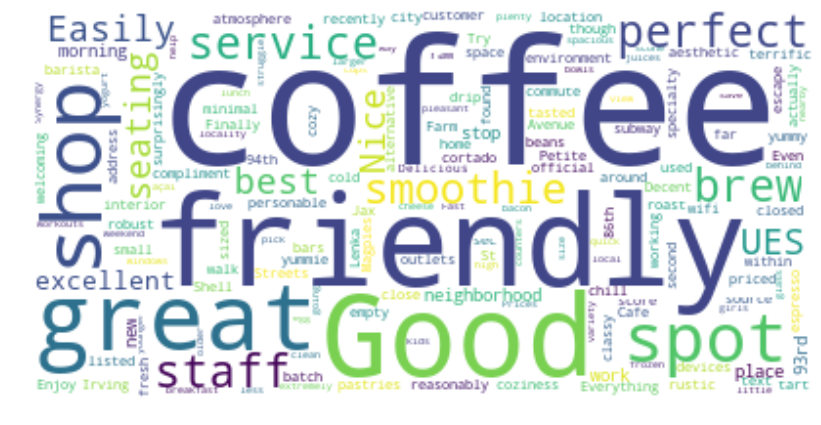

In [148]:
fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height
plt.imshow(carnegie_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

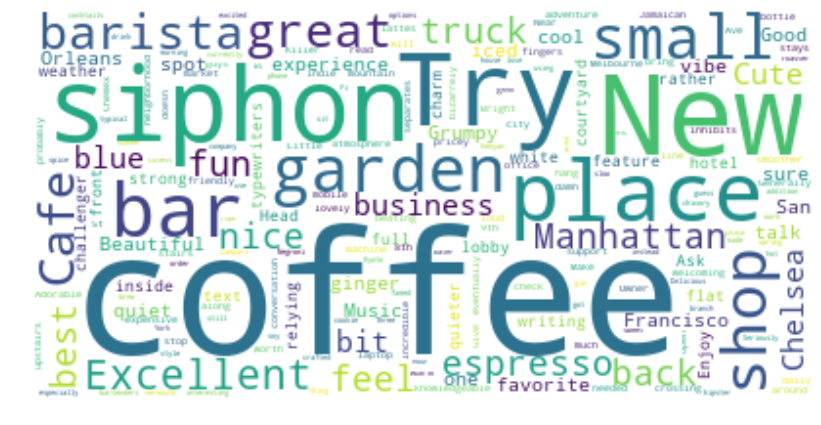

In [149]:
fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height
plt.imshow(chelsea_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

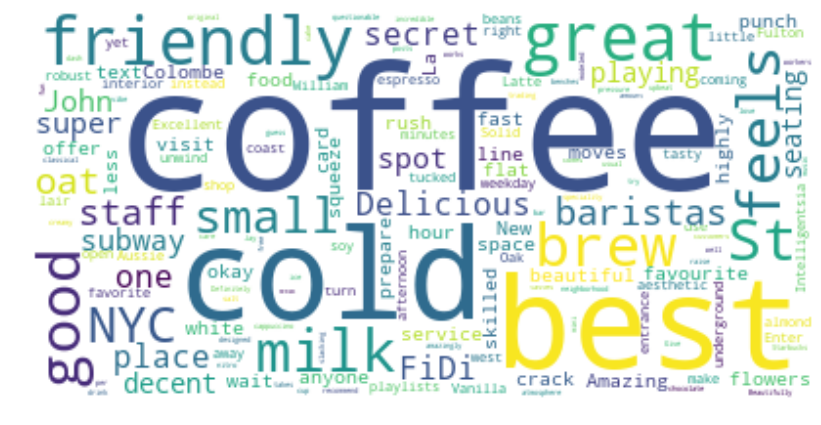

In [150]:
fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height
plt.imshow(financial_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

### Let's dig deeper and search for specific tips based on key workds such as 'work', 'wifi', 'outlets'

In [166]:
carnegie_text_list = carnegie_text.split()
chelsea_text_list = chelsea_text.split()
financial_text_list = financial_text.split()

In [167]:
import re
from collections import Counter
carnegie_words = re.findall(r'\w+', open('CarnegieWords.txt').read().lower())
Counter(carnegie_words).most_common(10)

[('the', 20),
 ('and', 15),
 ('coffee', 11),
 ('a', 10),
 ('to', 8),
 ('is', 7),
 ('for', 7),
 ('on', 5),
 ('friendly', 5),
 ('very', 4)]

In [181]:
carnegie_text_list = pd.DataFrame(Counter(carnegie_words).most_common(),
                             columns=['Words', 'Count'])

carnegie_text_list.head()

,Words,Count
0,the,20
1,and,15
2,coffee,11
3,a,10
4,to,8


In [241]:
carnegie_key_list = carnegie_text_list.loc[(carnegie_text_list['Words'] == 'work') | 
                                           (carnegie_text_list['Words'] == 'wifi') |
                                           (carnegie_text_list['Words'] == 'internet') | 
                                           (carnegie_text_list['Words'] == 'meet') | 
                                           (carnegie_text_list['Words'] == 'study') | 
                                           (carnegie_text_list['Words'] == 'laptop') | 
                                           (carnegie_text_list['Words'] == 'outlet') | 
                                           (carnegie_text_list['Words'] == 'outlets')]
carnegie_key_list

,Words,Count
44,work,2
87,wifi,1
148,outlets,1


In [173]:
chelsea_words = re.findall(r'\w+', open('ChelseaWords.txt').read().lower())
chelsea_text_list = pd.DataFrame(Counter(chelsea_words).most_common(),
                             columns=['Words', 'Count'])

chelsea_text_list.head()

,Words,Count
0,the,35
1,coffee,14
2,in,14
3,is,11
4,a,11


In [243]:
chelsea_text_list = chelsea_text_list.loc[(chelsea_text_list['Words'] == 'work') | 
                                           (chelsea_text_list['Words'] == 'wifi') |
                                           (chelsea_text_list['Words'] == 'internet') | 
                                           (chelsea_text_list['Words'] == 'meet') | 
                                           (chelsea_text_list['Words'] == 'study') | 
                                           (carnegie_text_list['Words'] == 'laptop') | 
                                           (chelsea_text_list['Words'] == 'outlet') | 
                                           (chelsea_text_list['Words'] == 'outlets')]
chelsea_text_list

,Words,Count
198,work,1


In [178]:
financial_words = re.findall(r'\w+', open('FinancialWords.txt').read().lower())
financial_text_list = pd.DataFrame(Counter(financial_words).most_common(),
                             columns=['Words', 'Count'])

financial_text_list.head()

,Words,Count
0,the,15
1,a,13
2,and,11
3,of,8
4,coffee,8


In [246]:
financial_text_list = financial_text_list.loc[(financial_text_list['Words'] == 'work') | 
                                           (financial_text_list['Words'] == 'wifi') |
                                           (financial_text_list['Words'] == 'internet') | 
                                           (financial_text_list['Words'] == 'meet') | 
                                           (financial_text_list['Words'] == 'study') | 
                                           (carnegie_text_list['Words'] == 'laptop') | 
                                           (financial_text_list['Words'] == 'outlet') | 
                                           (financial_text_list['Words'] == 'outlets')]
financial_text_list

,Words,Count


In [200]:
carnegie_tips_key = carnegie_tips.loc[(carnegie_tips['text'].str.contains('work'))| 
                                  (carnegie_tips['text'].str.contains('wifi')) |
                                  (carnegie_tips['text'].str.contains('outlets'))]
carnegie_tips_key

,venue_id,text,agreeCount,disagreeCount,id,user.firstName,user.lastName,user.id
1,51ae935b7dd2de27a217609e,"Just an all around great neighborhood spot for yummy pastries, good fresh roast coffee, good atmosphere/customer service, coziness, and wifi...within 60 sec walk from home! score.",7,0,54e374c7498edb2a1d4d5d33,Lanre,A,52161641
1,5abb96b31f8ed641d150eafa,Very classy but welcoming interior. It was surprisingly empty and would be an excellent alternative to Cafe Jax if you like working at coffee shops.,5,0,5ac984f4e65d0c69c40152da,Mika,S,136200186
0,5330323b498e2836f173cf9e,"The space is nice, and I easily found and used outlets for my devices. Enjoy a cold brew with a Magpies tart! Delicious.",3,0,55cb5b62498e9ccd7c0babbe,Nia,S,32910677
0,4da39a219935a0933d0bcd6f,The girls who work here are extremely friendly and are so pleasant when I stop in at 7:15 on my way to work. The best(less than $5) bacon egg&cheese in the neighborhood! Great coffee and smoothies,6,0,51c755ca498e5b52235d8cc9,Spencer,V,59170133
1,552a7fbb498e1e8662ac8146,"Great variety of juices, smoothies and açai bowls after my workouts at Synergy. They also have frozen yogurt for the kids younger and older. ;)",0,0,5d8668a2f96bc00007b08776,Alvin,S,87761942


In [198]:
chelsea_tips_keys = chelsea_tips.loc[(chelsea_tips['text'].str.contains('work'))| 
                                  (chelsea_tips['text'].str.contains('wifi')) |
                                  (chelsea_tips['text'].str.contains('outlets'))]
chelsea_tips_keys

,venue_id,text,agreeCount,disagreeCount,id,user.firstName,user.lastName,user.id
1,45d1a484f964a520af421fe3,Cafe Grumpy is an interesting place to work. I love the hipster vibe and am excited to sit in their garden in the spring and summer. They don't have Wi-Fi but you can use your phone hot spot.,5,0,5ab7a1e5da2e00604cce411f,Elizabeth,B,131137


In [199]:
financial_tips_keys = financial_tips.loc[(financial_tips['text'].str.contains('work'))| 
                                  (financial_tips['text'].str.contains('wifi')) |
                                  (financial_tips['text'].str.contains('outlets'))]
financial_tips_keys

,venue_id,text,agreeCount,disagreeCount,id,user.firstName,user.lastName,user.id
1,4a9ff5d9f964a520ba3d20e3,"Jay at the bar is the best. He works super well under pressure, and takes care of his customers when the workers are slacking. Give him a raise.",5,0,53ac12ce11d2d09c4bd06ebb,Laura,NaN,11176379


### Now let's go back to the map and see where these coffee shops are located

In [209]:
carnegie_venues_selected = manhattan_venues.loc[(manhattan_venues['Venue_ID'] == ('51ae935b7dd2de27a217609e')) |
                                               (manhattan_venues['Venue_ID'] == ('5abb96b31f8ed641d150eafa' )) |
                                               (manhattan_venues['Venue_ID'] == ('5330323b498e2836f173cf9e')) ]
carnegie_venues_selected

,Neighborhood,Neighborhood_Latitude,Neighborhood_Longitude,Venue,Venue_ID,Venue_Latitude,Venue_Longitude,Venue_Category
2318,Carnegie Hill,40.782683,-73.953256,DTUT,51ae935b7dd2de27a217609e,40.780818,-73.949350,Coffee Shop
2346,Carnegie Hill,40.782683,-73.953256,Variety Coffee Roasters,5abb96b31f8ed641d150eafa,40.778899,-73.955900,Coffee Shop
2362,Carnegie Hill,40.782683,-73.953256,Starbucks,5330323b498e2836f173cf9e,40.779546,-73.953552,Coffee Shop


In [236]:
map_carnegie = folium.Map(location=[latitude, longitude], zoom_start=14)

for lat, lng, label in zip(carnegie_venues_selected['Venue_Latitude'], carnegie_venues_selected['Venue_Longitude'], carnegie_venues_selected['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_carnegie)  

    for lat, lng, label in zip(latitudes, longitudes, labels):
        folium.Marker([lat, lng], popup=label).add_to(map_carnegie) 

map_carnegie